### Test of data instantiation

In [1]:
import torch
from torch.utils.data import DataLoader 
import numpy as np
import os
import torchvision.transforms as T
from torchvision.transforms import functional as F

import src.dfmaker as dfmaker
import src.BWDatasets as BWDatasets
import src.utility as utility
import src.train_eval as te

from paddleocr import PaddleOCR
import paddle


c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Ensure Reproducibility

In [2]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [14]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [15]:
# Lyngøy
label_path_lyng = "dataset/datasets/lyngoy/ringcodes.csv"
image_path_lyng = "dataset/datasets/lyngoy/images"
bb_path_lyng = "dataset/datasets/lyngoy/labels"

# RF
label_path_rf = "dataset/datasets/rf/ringcodes.csv"
image_path_rf = "dataset/datasets/rf/images"
bb_path_rf = "dataset/datasets/rf/labels"

# Ringmerkingno
label_path_rno = "dataset/datasets/ringmerkingno/ringcodes.csv"
image_path_rno = "dataset/datasets/ringmerkingno/images"
bb_path_rno = "dataset/datasets/ringmerkingno/labels"

max_n_single = 10
max_n_all = None
height = 240 # 240 worked best for the provided dataset
transform = T.Compose([
    T.Lambda(lambda x: F.rotate(x, -90, expand=True)),
    T.Resize((height, utility.find_width(height))) 
])

df_lyng = dfmaker.make_dataframe(labels_path=label_path_lyng, img_path=image_path_lyng, bb_path=bb_path_lyng, max_n=max_n_single)
df_rf = dfmaker.make_dataframe(labels_path=label_path_rf, img_path=image_path_rf, bb_path=bb_path_rf, max_n=max_n_single)
df_rno = dfmaker.make_dataframe(labels_path=label_path_rno, img_path=image_path_rno, bb_path=bb_path_rno, max_n=max_n_single)
complete_df = dfmaker.combine_dfs([df_lyng, df_rf, df_rno])

exp_dataset = BWDatasets.TrainDataSet(df=complete_df, transform=transform, max_n=max_n_all)


In [ ]:
#std, mean = torch.std_mean(exp_dataset[:]["ocr_image"], (0,2,3))

RuntimeError: [Errno 2] No such file or directory: '['dataset/datasets/lyngoy/images\\20180426_sildemake_4k+_J2TM_realfagsbygget_.JPG', 'dataset/datasets/lyngoy/images\\20180518_sildemake_4k+_J537H_lyngoy_sildemakemyr_ost_.JPG', 'dataset/datasets/lyngoy/images\\20180519_svartbak_4k+_JJ168_lyngoy_viltkamera_.JPG', 'dataset/datasets/lyngoy/images\\20180520_svartbak_4k+_JJ168_lyngoy_viltkamera3_.JPG', 'dataset/datasets/lyngoy/images\\20180520_svartbak_4k+_JJ168_lyngoy_viltkamera4_.JPG', 'dataset/datasets/lyngoy/images\\20180525_gramake_4k+_JL830_lyngoy_viltkamera2_.JPG', 'dataset/datasets/lyngoy/images\\20180525_gramake_4k+_JL830_lyngoy_viltkamera_.JPG', 'dataset/datasets/lyngoy/images\\20180526_sildemake_4k+_J448H_lyngoy_viltkamera2_.JPG', 'dataset/datasets/lyngoy/images\\20180526_sildemake_4k+_J448H_lyngoy_viltkamera_.JPG', 'dataset/datasets/lyngoy/images\\20180605_sildemake_4k+_JL439_lyngoy_.JPG', 'dataset/datasets/rf/images\\20240408-145102.064779(162.29,-4.57,9209.0).jpg', 'dataset/datasets/rf/images\\20240408-145142.722154(103.96,-3.69,10150.0).jpg', 'dataset/datasets/rf/images\\20240408-145459.652977(162.36,-4.64,7886.0).jpg', 'dataset/datasets/rf/images\\20240408-145544.814361(93.19,-3.36,10055.0).jpg', 'dataset/datasets/rf/images\\20240408-145602.037977(80.53,-3.07,10338.0).jpg', 'dataset/datasets/rf/images\\20240408-152700.065700(-163.15,-3.84,10636.0).jpg', 'dataset/datasets/rf/images\\20240408-152816.726683(132.59,-1.38,10382.0).jpg', 'dataset/datasets/rf/images\\20240408-153023.711880(167.64,-5.87,8263.0).jpg', 'dataset/datasets/rf/images\\20240408-153158.880806(100.81,-19.02,3832.0).jpg', 'dataset/datasets/rf/images\\20240408-154814(-173.23,-5.81,8512.0).jpg', 'dataset/datasets/ringmerkingno/images\\LABW(WT);LBM_20120228142549_79.jpg', 'dataset/datasets/ringmerkingno/images\\LAM;RBWN(J0K8)_20140125233654_1116.jpg', 'dataset/datasets/ringmerkingno/images\\LAM;RBWN(J0K8)_20190120000322_1116.jpg', 'dataset/datasets/ringmerkingno/images\\LAM;RBWN(JA0H)_20121029120844_1116.jpg', 'dataset/datasets/ringmerkingno/images\\LANW(CN);LBM_20120227142458_79.jpg', 'dataset/datasets/ringmerkingno/images\\LBBO(232)_20121119155111_79.jpg', 'dataset/datasets/ringmerkingno/images\\LBBO(924)_20120228083159_79.jpg', 'dataset/datasets/ringmerkingno/images\\LBBO(CZP)_20121119155815_79.jpg', 'dataset/datasets/ringmerkingno/images\\LBBO(CZP)_20121119155827_79.jpg', 'dataset/datasets/ringmerkingno/images\\LBBW(210E)_20240706180050_385.jpg']'

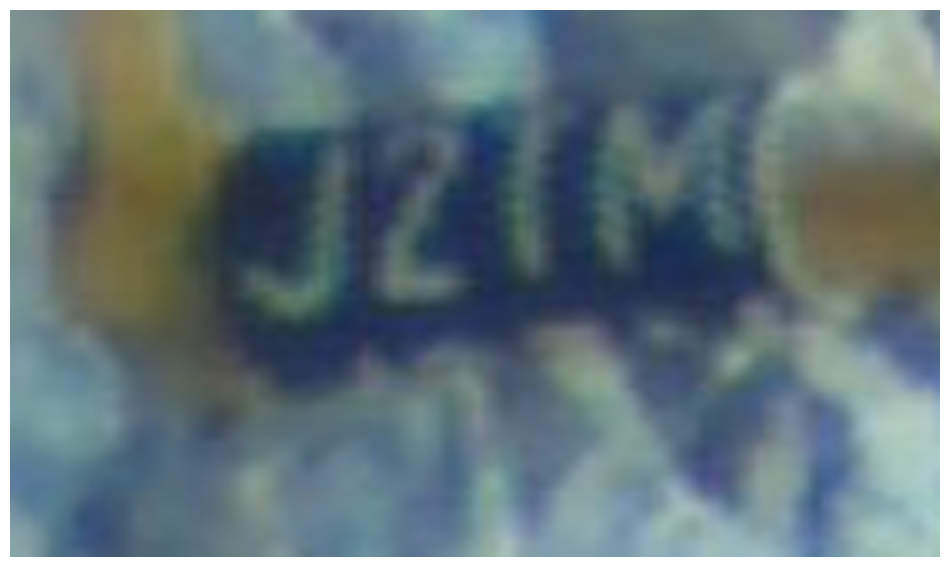

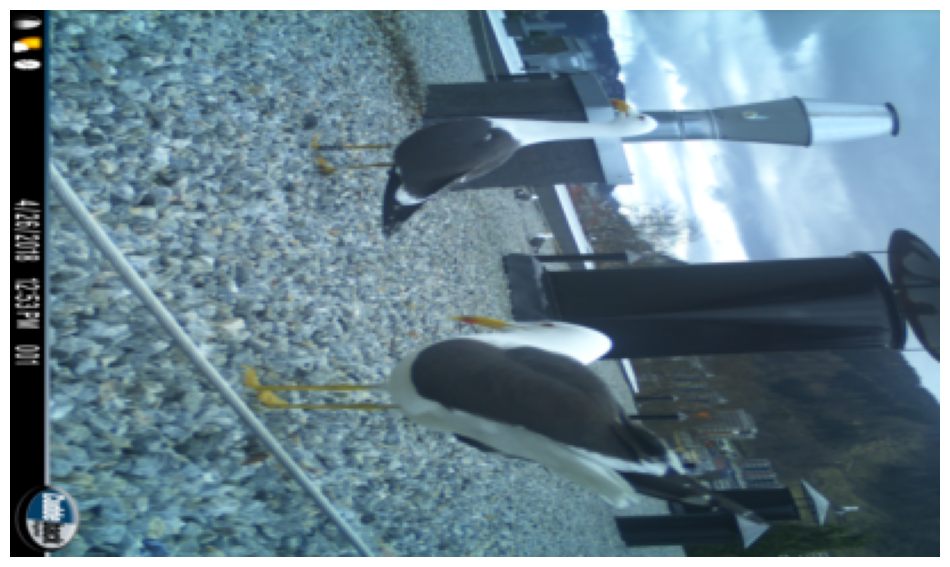

In [17]:
data = exp_dataset[0]

utility.draw_image(data["ocr_image"])
utility.draw_image(data["image"])


In [18]:
#stop



In [19]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5650.16it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2965.92it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2925.58it/s]
Creating model: ('PP-OCRv5_server_rec', 

In [ ]:
exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=False, generator=generator)


In [21]:
preds, labels = te.prediction(exp_loader, ocr)


In [ ]:
evaluation = te.evaluate_model(preds=preds, labels=labels)

F1 Score: 0.43478259444236755
Accuracy: 0.13333334028720856


In [ ]:
print(f'F1 Score: {evaluation["F1 Score"]}')
print(f'Accuracy: {evaluation["Accuracy"]}')
print(f'Not Found: {evaluation["Not Found"]}')
print(f'Wrong: {evaluation["Wrong"]}')
print(f'Correct: {evaluation["Correct"]}')


NameError: name 'evaluation' is not defined